In [1]:
from numpy import random
from IPython.display import clear_output
import time
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from JSAnimation.IPython_display import display_animation, anim_to_html
from matplotlib import animation

In [2]:
def con_run(frame_n = 100,
            start_pop = 50,
            xd = 10,
            yd = 10,
            sample_n = 10,
            top_fraction = 0.1):
    
    first_frames = []
    scores = []
    overkill = int(sample_n/top_fraction)
    
    for i in range(int(sample_n/top_fraction)):
    
        coords = np.append(random.choice(range(xd),start_pop),
                           random.choice(range(yd),start_pop)).reshape(start_pop,2)
        a = np.repeat(0,xd*yd).reshape([xd,yd])
        
        for i in range(start_pop):
            
            a[coords[i][0],coords[i][1]] = 1
            
        b = add_border(a)

        for i in range(frame_n-1):
            
            c = life_step(b.reshape([i+1,xd*3, yd*3])[i,:]).flatten()
            b = np.append(b,c)

        b = b.reshape(frame_n, xd*3, yd*3)
        score = (frame_n*xd*yd*3*3)/np.sum(b) *np.var(b.reshape([frame_n*xd*yd*3*3]), axis=0)
        
        
        #try this
        first_frames = np.append(first_frames, a.flatten())
        scores = np.append(scores,score)
    #print(first_frames.shape)    
    top_scores_index = np.argsort(scores)[::-1][:sample_n]
    top_scores = scores[top_scores_index]
    top_first_frames = first_frames.reshape([overkill, xd*yd])[top_scores_index]
    #print(top_first_frames)

    return(top_first_frames,top_scores)

In [3]:
def add_border(x):
        background = np.repeat(0, x.shape[0] * x.shape[1] * 3 * 3).reshape([x.shape[0] * 3,
                                                                            x.shape[1] * 3])
        background[x.shape[0]:-x.shape[0], x.shape[1]:-x.shape[1]] = x
        return(background)

In [4]:
def life_step(X):
    
    """Game of life step using generator expressions"""
    
    nbrs_count = sum(np.roll(np.roll(X, i, 0), j, 1)
                     for i in (-1, 0, 1) for j in (-1, 0, 1)
                     if (i != 0 or j != 0))
    
    return (nbrs_count == 3) | (X & (nbrs_count == 2))

In [5]:
def life_animation(X, dpi=80, frames=10, interval=300, mode='loop'):
    
    X = np.asarray(X)
    assert X.ndim == 2
    X = X.astype(int) 
    X_blank = np.zeros_like(X)
    figsize = (X.shape[1] * 10. / dpi, X.shape[0] * 10. / dpi)  
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1], xticks=[], yticks=[], frameon=False)
    im = ax.imshow(X, cmap='hot', interpolation='nearest')
    im.set_clim(-0.05, 10)
    
    # initialization function: plot the background of each frame
    
    def init():
        
        im.set_data(X_blank)
        return (im,)
    
    # animation function.  This is called sequentially
    
    def animate(i):
        
        im.set_data(animate.X)
        animate.X = life_step(animate.X)
        
        return (im,)
    
    animate.X = X
    anim = animation.FuncAnimation(fig,
                                   animate,
                                   init_func=init,
                                   frames=frames,
                                   interval=interval)
    
    return display_animation(anim, default_mode=mode)      

In [6]:
def sig_func(x,y):
    return(1/(1+np.exp(-(np.dot(x,y)))))

In [7]:
def train_des(des_training_inputs,
              des_training_outputs,
              des_weights,
              iteration_n):
    
    for i in range(iteration_n):
        
        result = sig_func(des_training_inputs, des_weights)
        des_weights += np.dot(des_training_inputs.T,
                              (des_training_outputs - result) *
                              result *
                              (1 - result))
        
    return(des_weights)

In [8]:
def train_gen(gen_noise,
              gen_weights,
              des_weights,
              iteration_n,
              xd,
              yd):
    
    half_n = int(len(gen_noise)/2)
    #print(half_n)
    
    for i in range(iteration_n):
        
        generated = sig_func(gen_noise, gen_weights)
        
        #gen_with_border = [add_border(i.reshape([xd,yd])).flatten() for i in generated]
        
        
        result = np.argsort(sig_func(generated, des_weights).flatten())
        top = result[::-1][:half_n]
        bottom = result[:half_n]
        gen_weights += np.dot(gen_noise[top].T,
                              (generated[top] - generated[bottom]) * generated[bottom] * (1 - generated[bottom]))

    return(gen_weights)

In [9]:
iteration_n = 1000
sample_n = 100
xd = 10
yd = 10
frame_n = 100

des_td = con_run(frame_n = 100,
                 start_pop = 50,
                 xd = xd,
                 yd = yd,
                 sample_n = sample_n,
                 top_fraction = 0.1)

des_training_inputs = des_td[0]
des_training_outputs = des_td[1].reshape(sample_n,1)
des_weights = 2 * random.random((des_training_inputs.shape[1],
                                 des_training_outputs.shape[1])) - 1

gen_noise = random.choice([0,1], [sample_n, xd * yd])
gen_weights = 2 * random.random((xd*yd, xd*yd)) - 1

des_weights = train_des(des_training_inputs,
                        des_training_outputs,
                        des_weights,
                        iteration_n)

gen_weights = train_gen(gen_noise,
                        gen_weights,
                        des_weights,
                        iteration_n,
                        xd,
                        yd)

gen_result = sig_func(gen_noise, gen_weights)

im = np.unique(np.round(gen_result), axis=0)
score = sig_func(im, des_weights)
top = np.argsort(score)[::-1][0]
top_score = score[top]
top_im = im[top].reshape([xd,yd])

clear_output(wait=True)
print(top_im)
print(top_score)

[[1. 0. 0. 0. 1. 1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [1. 1. 0. 0. 1. 1. 0. 1. 1. 0.]
 [1. 1. 1. 1. 0. 0. 1. 0. 0. 0.]
 [1. 1. 1. 1. 0. 1. 1. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1. 1. 1. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 1. 0. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 1. 0. 1. 0. 0. 0.]]
[[1.]]



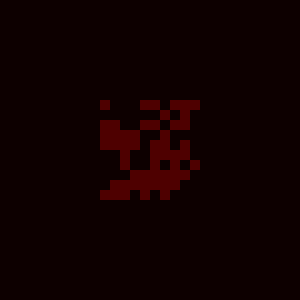
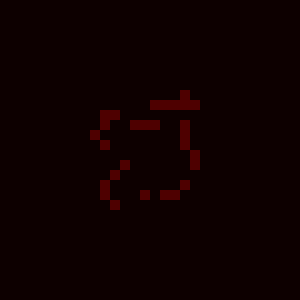
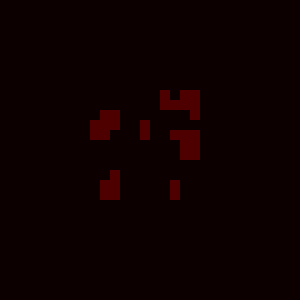
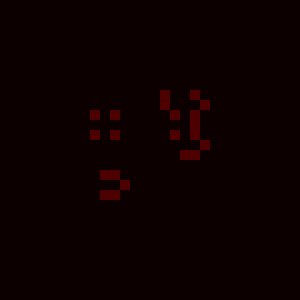
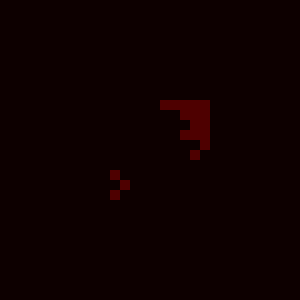
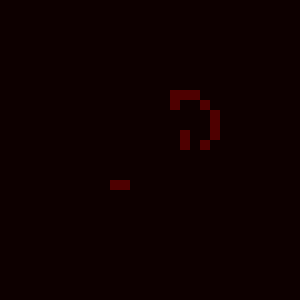
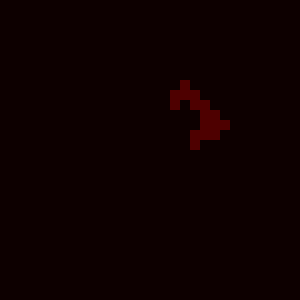
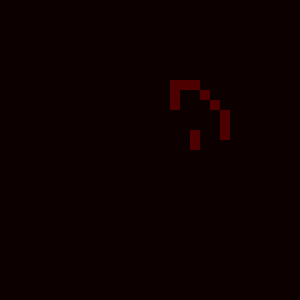
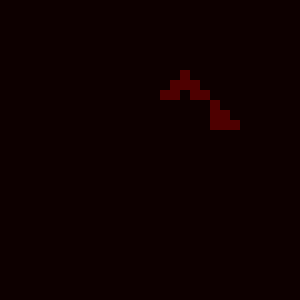
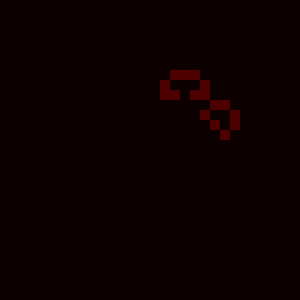
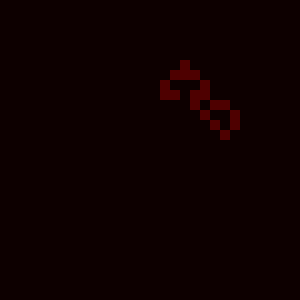
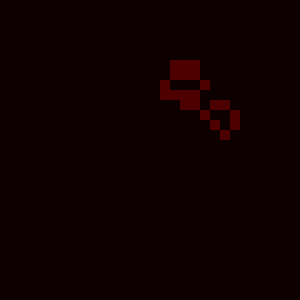
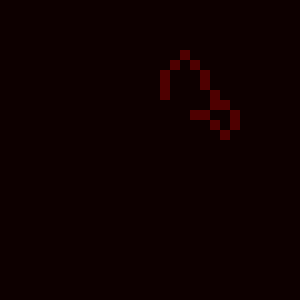
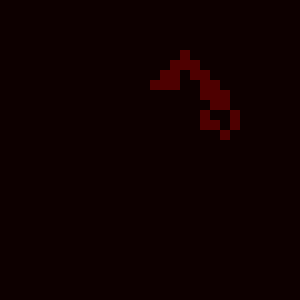
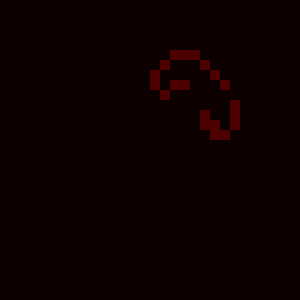
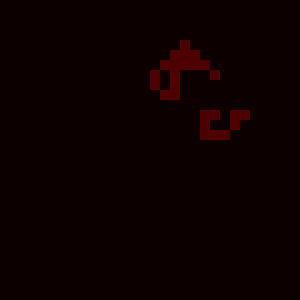
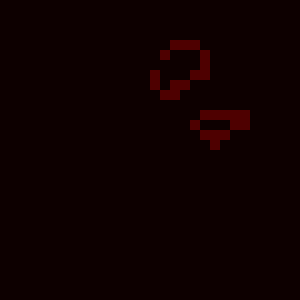
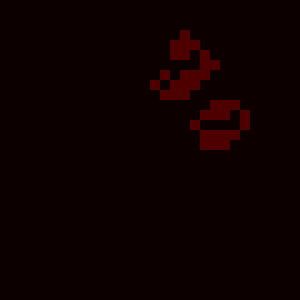
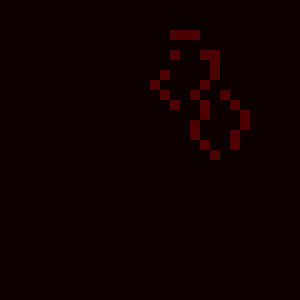
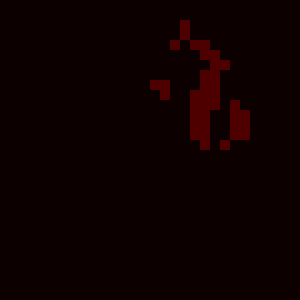
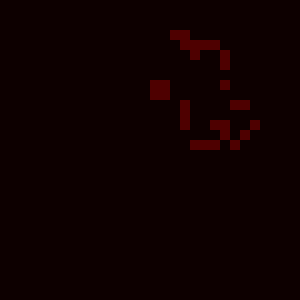
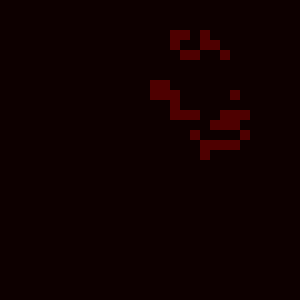
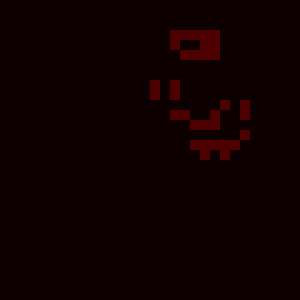
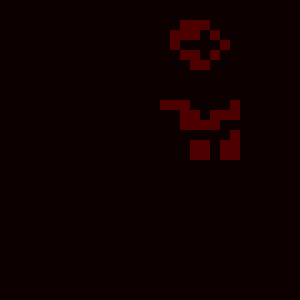
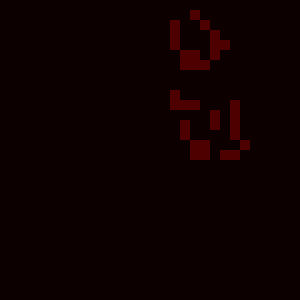
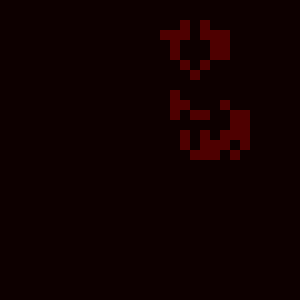
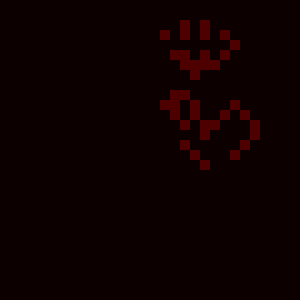
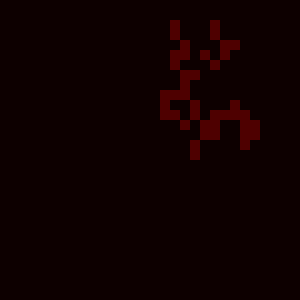
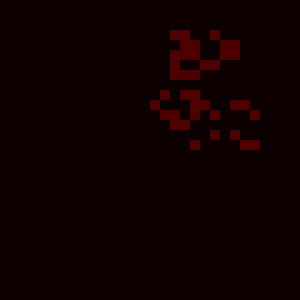
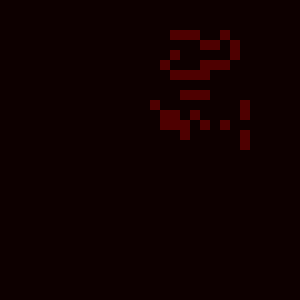
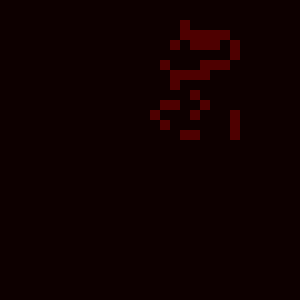
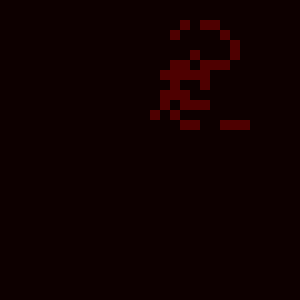
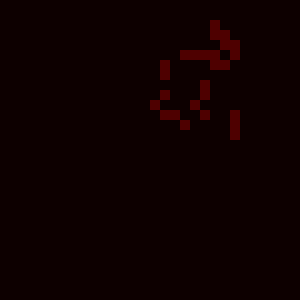
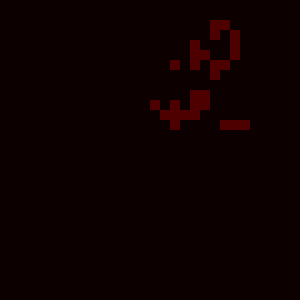
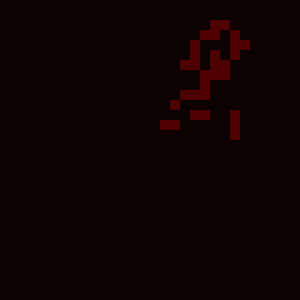
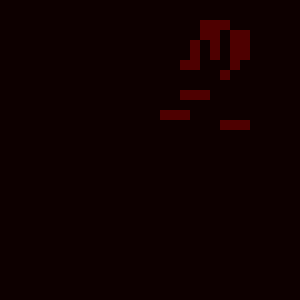
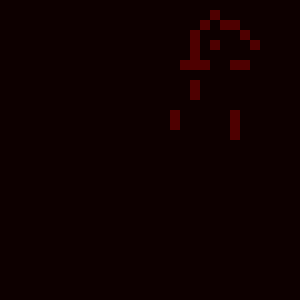
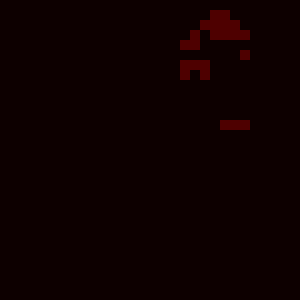
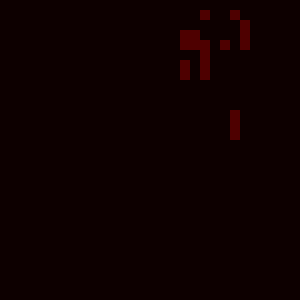
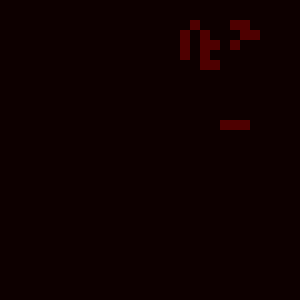
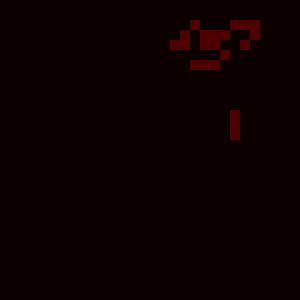
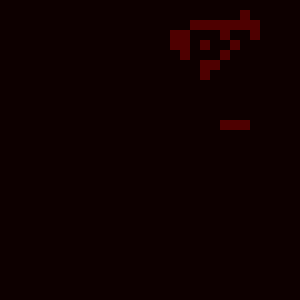
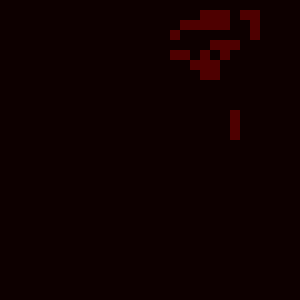
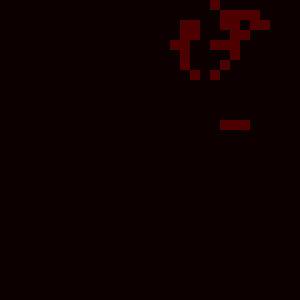
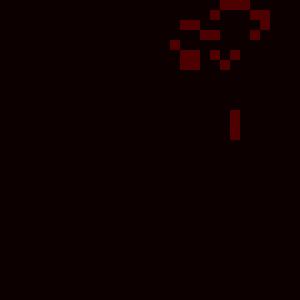
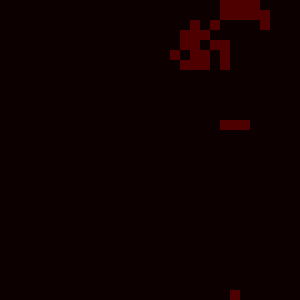
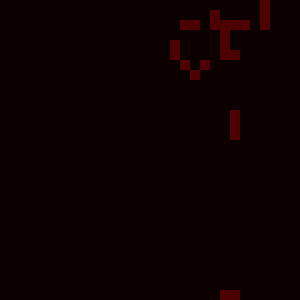
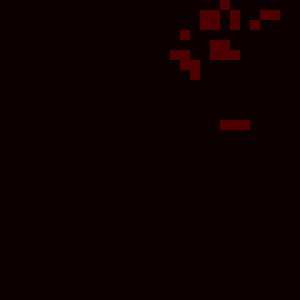
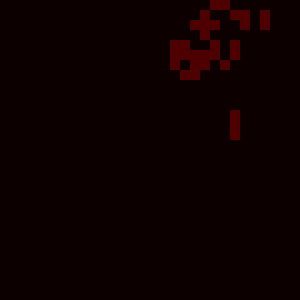
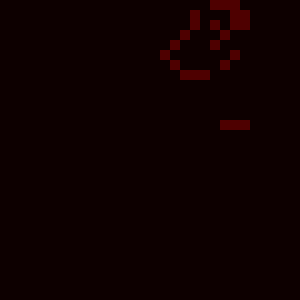
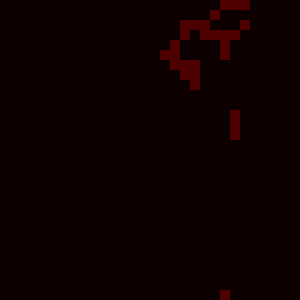
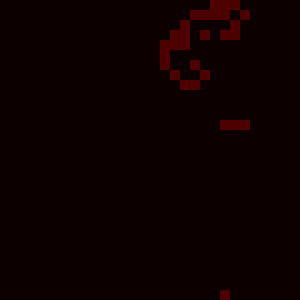
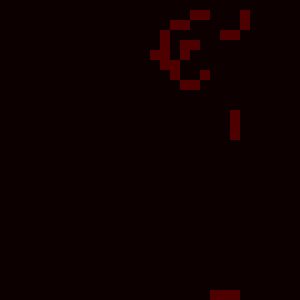
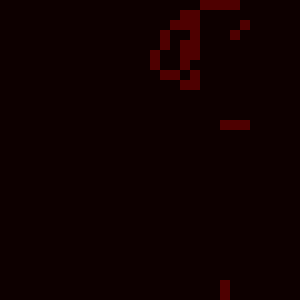
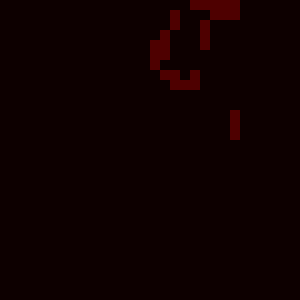
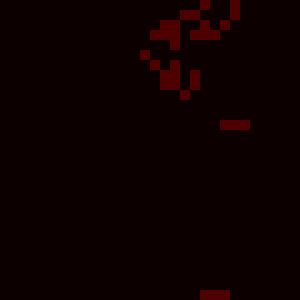
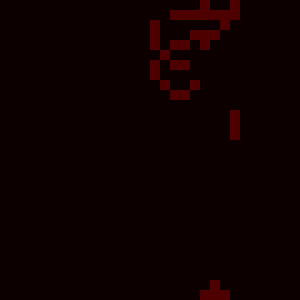
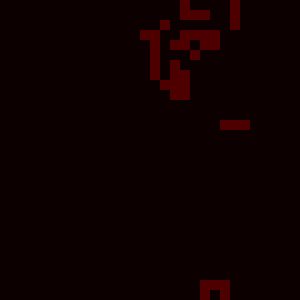
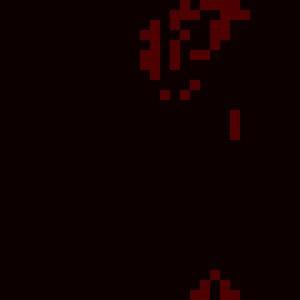
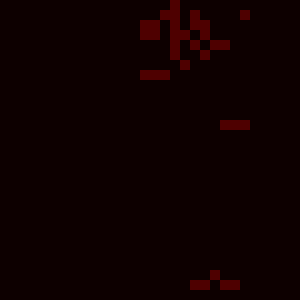
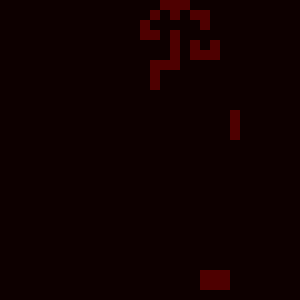
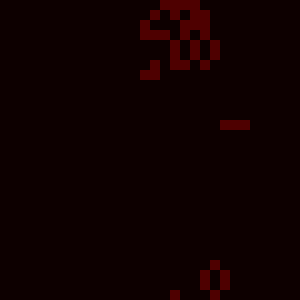
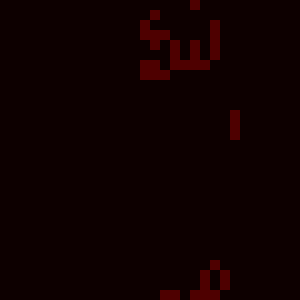
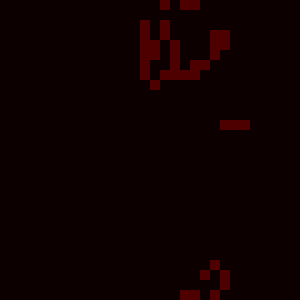
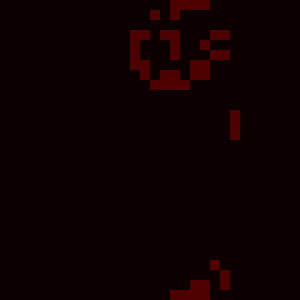
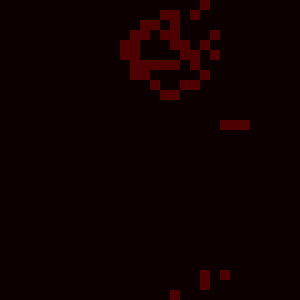
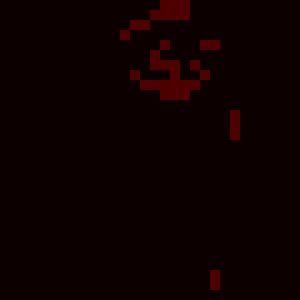
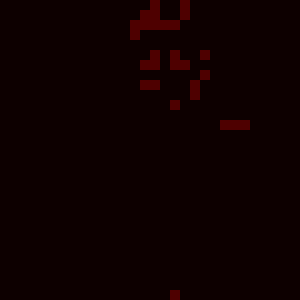
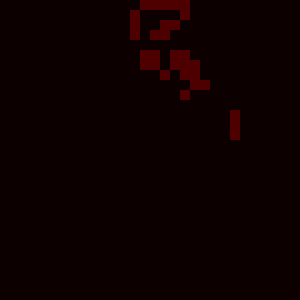
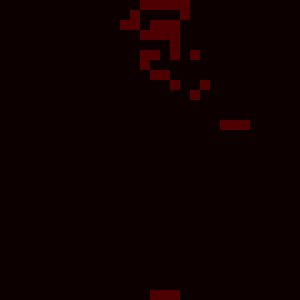
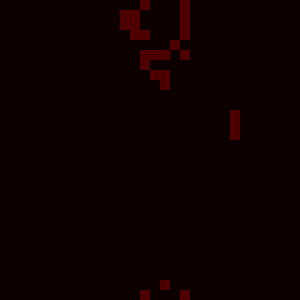
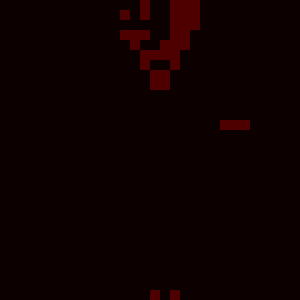
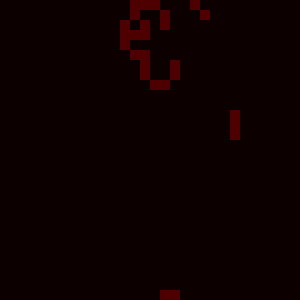
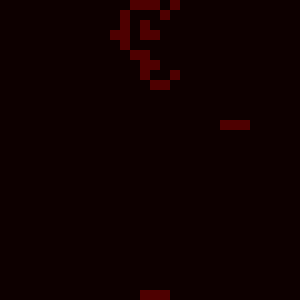
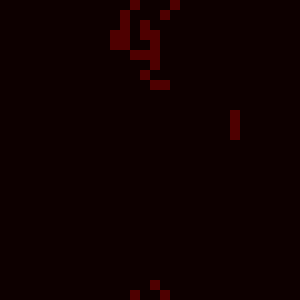
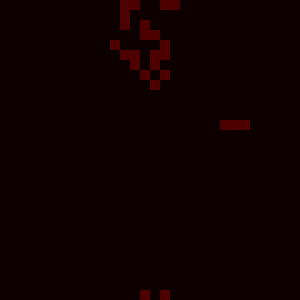
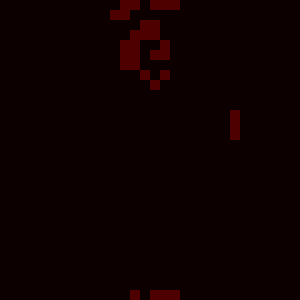
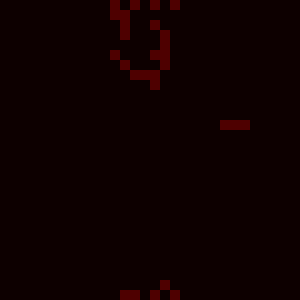
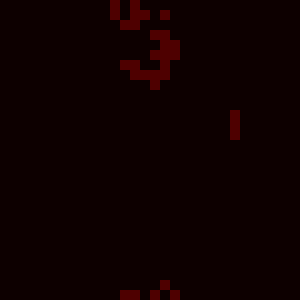
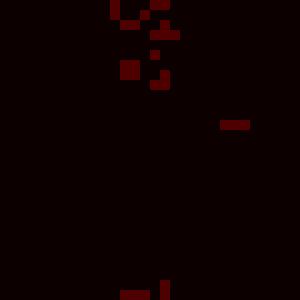
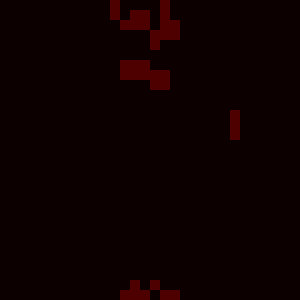
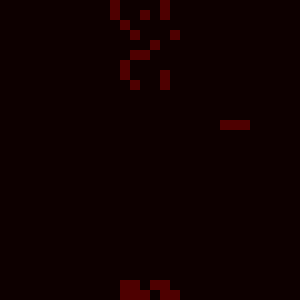
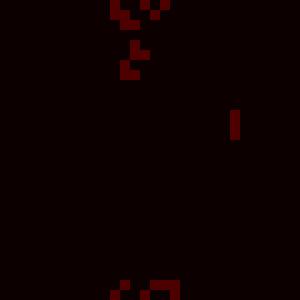
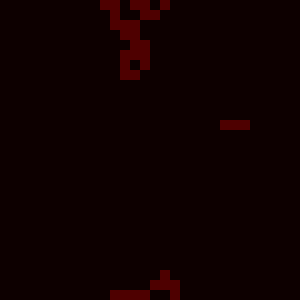
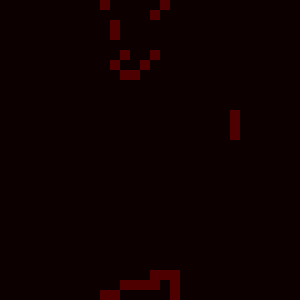
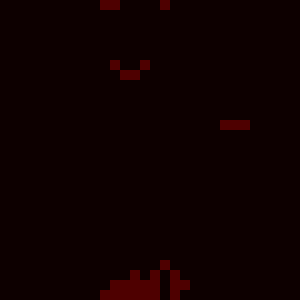
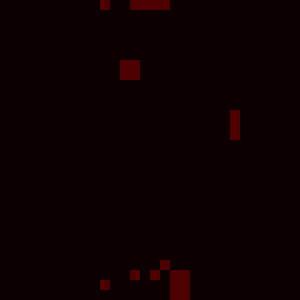
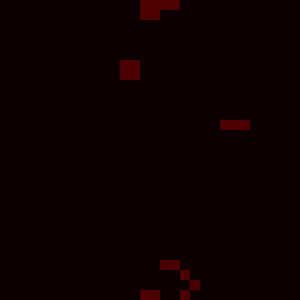
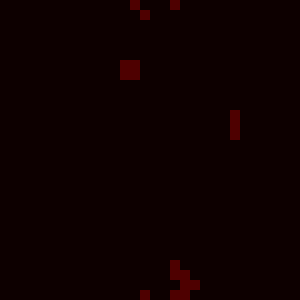
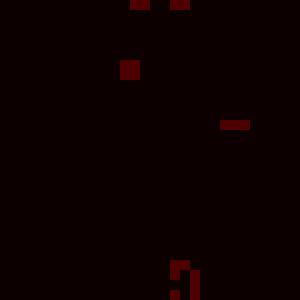
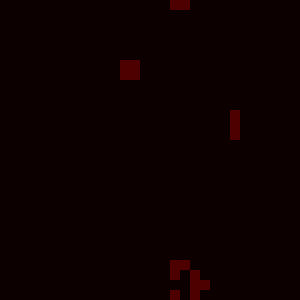
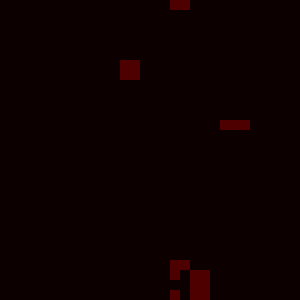
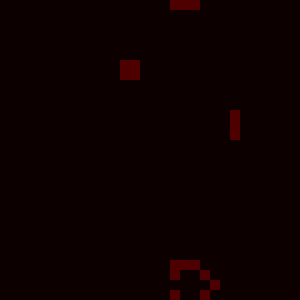
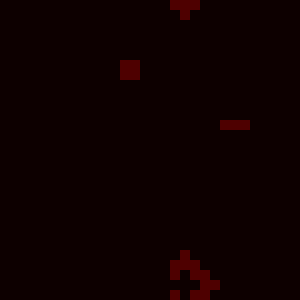
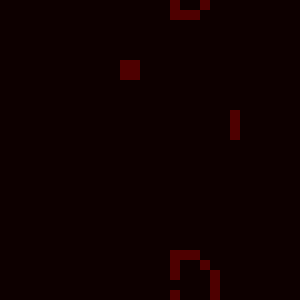
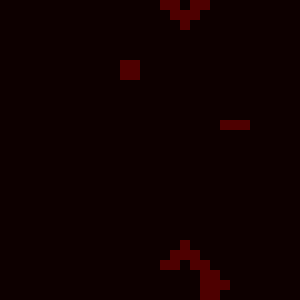
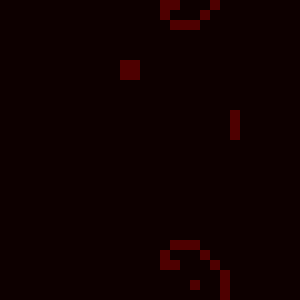
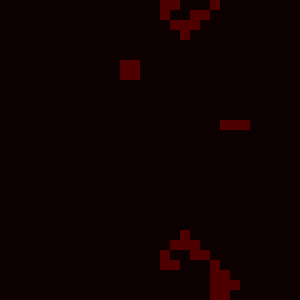
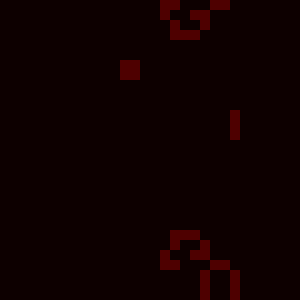
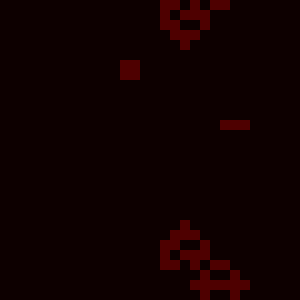

In [10]:
life_animation(add_border(top_im), dpi=15, frames=frame_n, interval=50, mode='once')